<a href="https://colab.research.google.com/github/stefarine/DMML2022_ROLEX/blob/main/DMML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importations, installations and statistics



##Importations & intallations

In [ ]:
!pip install -U spacy
!python -m spacy download fr
!python -m spacy download fr_core_news_sm
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git &> /dev/null
!pip install gensim
!pip install python-Levenshtein
!pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import spacy
from spacy import displacy
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
import csv
from tqdm import tqdm
import multiprocessing
import bs4 as bs
import urllib.request
import math
from nltk.stem.snowball import SnowballStemmer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import fr_core_news_sm
from pprint import pprint
import functools
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
import plotly.express as px
from datasets import Dataset, Value, ClassLabel, Features

In [3]:
random_state=0

df = pd.read_csv('training_data.csv')
df_pred = pd.read_csv('unlabelled_test_data.csv')

In [4]:
X = df['sentence']
y = df['difficulty']
X_pred = df_pred['sentence']

##Descriptive statistics and baseline

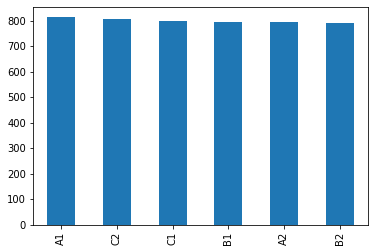

In [5]:
plot = y.value_counts().plot.bar()

In [6]:
y.describe()

count     4800
unique       6
top         A1
freq       813
Name: difficulty, dtype: object

In [7]:
base_rate = (df['difficulty'].value_counts().max()/df['difficulty'].shape[0]).round(4)
print('Base rate :')
print(base_rate)

Base rate :
0.1694


#Models

In [8]:
#split and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
##Models Functions

In [9]:
#Function to evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred,average='macro')
    recall = recall_score(true, pred,average='macro')
    f1 = f1_score(true, pred,average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [10]:
#Function to create a pipeline with TFIDF and a classifier
tfidf = TfidfVectorizer(ngram_range=(1, 1))

def pipeWithTFIDF(myClassifier):
  pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', myClassifier)])
  return pipe

In [18]:
#Function to fit a model, make pradiction with it and get evaluation stuff
def fitPredictAndEvaluateModel(pipe,name):
  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred= pipe.predict(X_test)

  #Exporting a file with the results
  predictions = pd.DataFrame(y_pred,columns=['difficulty'])
  predictions.to_csv(name+".csv")

  # Evaluation
  evaluate(y_test, y_pred)

  return y_pred

In [19]:
#Function to make a gride search and print the results
def getResultsGridSearch(myGs):
  #Pipeline preparation
  pipe = pipeWithTFIDF(myGs)

  #fit
  pipe.fit(X_train, y_train)

  #Print results
  print('Best Score : ')
  print(myGs.best_score_)
  print('Best Params : ')
  print(myGs.best_params_)

In [ ]:
##Data Cleaning Functions

In [20]:
#Function to remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, " ")
    return text

In [22]:
#Function for doing stemming
def return_stem(sentence):
    stemmer = SnowballStemmer(language='french')
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [ ]:
## Doc2Vec Functions

In [23]:
#Function to vectorize the Train set
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, feature_vectors

In [24]:
#Function to vectorize the prediction Set
def vector_for_pred(model, input_docs):
    sents = input_docs
    feature_vectors = [(model.infer_vector(doc.words, steps=100)) for doc in sents]
    return feature_vectors

In [ ]:
## CamemBERT Stuff

In [25]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

def tokenize_batch(samples, tokenizer):
    text = [sample["sentences"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["label"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [26]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

## Logistic Regression with TFidf vectoriser (no data cleaning)

In [27]:
#Define classifier and pipeline creation
LR = LogisticRegression(solver='lbfgs', random_state=0)
pipe_LR = pipeWithTFIDF(LR)

# fit, predict and evaluate
y_pred_LR = fitPredictAndEvaluateModel(pipe_LR,"pipe_LR")


CONFUSION MATRIX:
[[93 31 21 10  4  2]
 [54 60 30  6  6  8]
 [12 38 64 17  9 20]
 [ 6  6 15 66 27 24]
 [ 4  4 10 37 73 45]
 [ 7  8  8 19 24 92]]
ACCURACY SCORE:
0.4667
CLASSIFICATION REPORT:
	Precision: 0.4645
	Recall: 0.4677
	F1_Score: 0.4640


## KNN & hyperparameter optimization (no data cleaning)

In [28]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

###Knn Basic

In [29]:
# Define classifier and pipeline creation
knn = KNeighborsClassifier()
pipe_knn = pipeWithTFIDF(knn)

# fit, predict and evaluate
y_pred_knn = fitPredictAndEvaluateModel(pipe_knn,"pipe_knn")

CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


###Knn with hyperparameter optimization 

In [30]:
#Preparation of the GridSearch
seed = 0
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Score : 
0.3466145833333334
Best Params : 
{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}


In [32]:
# Define classifier and pipeline creation 
## This time we put the parameters we got in previous step
knn_GS = KNeighborsClassifier(n_neighbors = 11, weights = 'distance',metric = 'minkowski')
pipe_knn_GS = pipeWithTFIDF(knn_GS)

# fit, predict and evaluate
y_pred_knn_GS = fitPredictAndEvaluateModel(pipe_knn_GS,"pip_knn_GS")

CONFUSION MATRIX:
[[114  30  12   2   0   3]
 [ 91  56  14   0   1   2]
 [ 69  43  39   4   2   3]
 [ 40  25  20  37   7  15]
 [ 29  32  23  23  35  31]
 [ 32  27  17  15   8  59]]
ACCURACY SCORE:
0.3542
CLASSIFICATION REPORT:
	Precision: 0.4197
	Recall: 0.3543
	F1_Score: 0.3450


##Decision Tree & Hyperparameter optimization (no data cleaning))

In [33]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

### Decision tree Basic

In [34]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(random_state=0)
pipe_dt = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt = fitPredictAndEvaluateModel(pipe_dt,"pipe_dt")

CONFUSION MATRIX:
[[78 38 25 11  2  7]
 [49 54 33 18  3  7]
 [24 41 37 25 18 15]
 [10 20 30 38 24 22]
 [ 8 19 31 39 39 37]
 [15 13 28 33 30 39]]
ACCURACY SCORE:
0.2969
CLASSIFICATION REPORT:
	Precision: 0.2986
	Recall: 0.2969
	F1_Score: 0.2945


###Decision Tree with hyperparameter optimization

In [35]:
#Preparation of the GridSearch
seed = 0
grid_params = {'max_depth' : range(1,60)}
gs = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)


Fitting 3 folds for each of 59 candidates, totalling 177 fits
Best Score : 
0.32760416666666664
Best Params : 
{'max_depth': 54}


In [36]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(max_depth=43, random_state=0)
pipe_dt_GS = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt_GS = fitPredictAndEvaluateModel(pipe_dt_GS,"pipe_dt_GS")

CONFUSION MATRIX:
[[84 34 29  7  1  6]
 [48 53 36 15  4  8]
 [34 39 38 18 17 14]
 [ 9 23 27 44 19 22]
 [14 19 27 47 35 31]
 [16 12 27 37 32 34]]
ACCURACY SCORE:
0.3000
CLASSIFICATION REPORT:
	Precision: 0.2987
	Recall: 0.3009
	F1_Score: 0.2947


## Random Forest (no data cleaning)

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Define classifier and pipeline creation
rf = RandomForestClassifier(random_state=0)
pipe_rf = pipeWithTFIDF(rf)

# fit, predict and evaluate
y_pred_rf = fitPredictAndEvaluateModel(pipe_rf,"pipe_rf")

CONFUSION MATRIX:
[[125  20   7   7   2   0]
 [ 83  51  21   7   2   0]
 [ 39  39  47  20   6   9]
 [ 17  11  13  68  23  12]
 [ 16  16  23  46  46  26]
 [ 19  13  10  33  23  60]]
ACCURACY SCORE:
0.4135
CLASSIFICATION REPORT:
	Precision: 0.4223
	Recall: 0.4165
	F1_Score: 0.4014


##Logistic Regression with Crossvalidation (no data cleaning)

In [ ]:
LRCV = LogisticRegressionCV(solver='lbfgs',cv=5 ,max_iter=1000, random_state=0)

# Define classifier and pipeline creation
LRCV = LogisticRegressionCV(random_state=0)
pipe_LRCV = pipeWithTFIDF(LRCV)

# fit, predict and evaluate
y_pred_LRCV = fitPredictAndEvaluateModel(pipe_LRCV,"pipe_LRCV")

In [43]:
evaluate(y_test,y_pred_LRCV)

CONFUSION MATRIX:
[[91 34 20  9  4  3]
 [50 62 34  3  5 10]
 [12 35 72 14  7 20]
 [ 6  6 18 67 24 23]
 [ 3  5 13 40 65 47]
 [ 7  6  9 16 23 97]]
ACCURACY SCORE:
0.4729
CLASSIFICATION REPORT:
	Precision: 0.4723
	Recall: 0.4747
	F1_Score: 0.4703


##LinearSVC (no data cleaning)

In [44]:
from sklearn.svm import LinearSVC

In [45]:
# Define classifier and pipeline creation
Lsvc = LinearSVC(random_state=0)
pipe_Lsvc = pipeWithTFIDF(Lsvc)

# fit, predict and evaluate
y_pred_Lsvc = fitPredictAndEvaluateModel(pipe_Lsvc,"pipe_Lsvc")

CONFUSION MATRIX:
[[96 39 15  5  3  3]
 [52 65 32  3  5  7]
 [13 38 74 10  6 19]
 [ 5 10 19 61 24 25]
 [ 8  8 16 35 66 40]
 [ 6 11  8 16 22 95]]
ACCURACY SCORE:
0.4760
CLASSIFICATION REPORT:
	Precision: 0.4767
	Recall: 0.4769
	F1_Score: 0.4737


##MultinomialNB (no data cleaning)

In [50]:
from sklearn.naive_bayes import MultinomialNB

In [51]:
# Define classifier and pipeline creation
mnb = MultinomialNB()
pipe_mnb = pipeWithTFIDF(mnb)

# fit, predict and evaluate
y_pred_mnb = fitPredictAndEvaluateModel(pipe_mnb,"pipe_mnb")

CONFUSION MATRIX:
[[ 84  44  25   4   1   3]
 [ 39  79  31   3   2  10]
 [  7  43  80   6   4  20]
 [  1  10  23  60  20  30]
 [  2   9  15  25  53  69]
 [  5  13   8  10  15 107]]
ACCURACY SCORE:
0.4823
CLASSIFICATION REPORT:
	Precision: 0.5014
	Recall: 0.4839
	F1_Score: 0.4795


##Ensemble Classifier (no data cleaning)



In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
#Definition of an ensemble with a LR and a MNB
soft_voting_clf = VotingClassifier(estimators=[('LR', pipe_LR), ('mnb', pipe_mnb) ], voting='soft')

#Train
soft_voting_clf.fit(X_train, y_train) # training

#Pred
y_pred = soft_voting_clf.predict(X_test)

#Exporting a file with the results
predictions = pd.DataFrame(y_pred,columns=['difficulty'])
predictions.to_csv("ensemble_LR_MNB.csv")

#Evaluate
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[ 91  36  22   7   2   3]
 [ 48  69  30   4   4   9]
 [ 12  38  70  13   5  22]
 [  5   4  18  65  26  26]
 [  4   5  15  32  63  54]
 [  3   9  10  15  18 103]]
ACCURACY SCORE:
0.4802
CLASSIFICATION REPORT:
	Precision: 0.4829
	Recall: 0.4818
	F1_Score: 0.4773


##Doc2Vec & Logistic Regression (With data cleaning)

###Data Cleaning

#### StopWords and punctuation

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('fr_core_news_sm')

In [55]:
#Convert to lowercase
df['sentence'] = df['sentence'].str.lower()
df_pred['sentence'] = df_pred['sentence'].str.lower()

#Remove punctuation
df['sentence'] = df['sentence'].apply(remove_punctuations)
df_pred['sentence'] = df_pred['sentence'].apply(remove_punctuations)

In [56]:
#Define list of stopwords
french_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
french_stopwords.add('a')
french_stopwords.add('c')
french_stopwords.add('d')
french_stopwords.add('e')
french_stopwords.add('j')
french_stopwords.add('l')
french_stopwords.add('m')
french_stopwords.add('n')
french_stopwords.add('s')
french_stopwords.add('t')
french_stopwords.add('y')
french_stopwords.add('qu')

In [57]:
#Remove stopwords
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (french_stopwords)]))
df_pred['sentence'] = df_pred['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (french_stopwords)]))
df_pred.head(5)

,id,sentence
0,0,dûmes excuser propos eûmes prononcés
1,1,pouvez savoir plaisir recevoir bonne nouvelle
2,2,paradoxalement boire froid bonne parade
3,3,étonnant saison mystérieuse
4,4,corps golo essence surnaturelle monture arrang...


#### Tokenization

In [58]:
#Tokenize
df['tocken_without_stopwords'] = [nlp(text) for text in df.sentence]

#add a columns with the lengh 
df['len'] = [len(token) for token in df.tocken_without_stopwords]
df.head()

,id,sentence,difficulty,tocken_without_stopwords,len
0,0,coûts kilométriques réels diverger sensiblemen...,C1,"(coûts, kilométriques, réels, diverger, sensib...",21
1,1,bleu couleur préférée aime vert,A1,"(bleu, couleur, préférée, aime, vert)",5
2,2,test niveau français site internet école,A1,"(test, niveau, français, site, internet, école)",6
3,3,mari boston,A1,"(mari, boston)",2
4,4,écoles commerce couloirs places financières ar...,B1,"(écoles, commerce, couloirs, places, financièr...",19


#### Stemming

In [59]:
#Removing the end of the worlds and adding a collumn with a numerical label
df['stemmed'] = [return_stem(text) for text in df.sentence]
df_pred['stemmed'] = [return_stem(text) for text in df_pred.sentence]
df['label'] = pd.factorize(df['difficulty'])[0] + 1
df.head()

,id,sentence,difficulty,tocken_without_stopwords,len,stemmed,label
0,0,coûts kilométriques réels diverger sensiblemen...,C1,"(coûts, kilométriques, réels, diverger, sensib...",21,"[coût, kilometr, réel, diverg, sensibl, valeur...",1
1,1,bleu couleur préférée aime vert,A1,"(bleu, couleur, préférée, aime, vert)",5,"[bleu, couleur, préfer, aim, vert]",2
2,2,test niveau français site internet école,A1,"(test, niveau, français, site, internet, école)",6,"[test, niveau, franc, sit, internet, écol]",2
3,3,mari boston,A1,"(mari, boston)",2,"[mar, boston]",2
4,4,écoles commerce couloirs places financières ar...,B1,"(écoles, commerce, couloirs, places, financièr...",19,"[écol, commerc, couloir, plac, financi, arriv,...",3


###Doc2Vec

In [ ]:
#Putting Data in a TaggedDocument format
documents = []
testdocuments = []
for ind in df.index:
  documents.append(TaggedDocument(df['stemmed'][ind],
      [df['label'][ind]]))

for ind in df_pred.index:
  testdocuments.append(TaggedDocument(df_pred['stemmed'][ind],
      tags=None))
testdocuments

In [61]:
#Creating a train set and a test set on the TaggedDocument
document_train, document_test = train_test_split(documents, test_size=0.2, random_state=0)

In [ ]:
# Preparation BagOfWords
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(document_train)])
document = utils.shuffle(document_train)
model_dbow.train(documents, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [63]:
# Vectorization
y_train, X_train = vector_for_learning(model_dbow, document_train)
y_test, X_test = vector_for_learning(model_dbow, document_test)

###Linear Regression CV

In [ ]:
# Fit model on training set
logreg = LogisticRegressionCV(solver='lbfgs' ,max_iter=5000, random_state=0)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

In [65]:
# Evaluation
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[ 98   8  10   8  23  26]
 [  3 120  12  24   2   0]
 [  9  21  93  17  11   9]
 [  2  48  20  87   5   2]
 [  9   4  10  11  97  13]
 [ 22   8   4   3  20 101]]
ACCURACY SCORE:
0.6208
CLASSIFICATION REPORT:
	Precision: 0.6244
	Recall: 0.6227
	F1_Score: 0.6202


##CamemBERT

In [66]:
## Transformation dataFrame to dataSet (ALL DATA)
labels = df['difficulty'].values
sentences = df['sentence'].values
df = pd.DataFrame({"sentences": sentences, "label": labels})# define data set object
features = Features({"sentences": Value("string"), "label": ClassLabel(num_classes=6, names=['A1','A2','B1','B2','C1','C2'])})
ds = Dataset.from_pandas(df, features=features)
ds.features

{'sentences': Value(dtype='string', id=None),
 'label': ClassLabel(names=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], id=None)}

In [68]:
#Sets preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

## Transformation dataFrame to dataSet (TRAIN DATA)
labels = y_train['difficulty'].values
sentences = X_train['sentence'].values
df = pd.DataFrame({"sentences": sentences, "label": labels})# define data set object
features = Features({"sentences": Value("string"), "label": ClassLabel(num_classes=6, names=['A1','A2','B1','B2','C1','C2'])})
ds_train = Dataset.from_pandas(df, features=features)
ds_train.features

{'sentences': Value(dtype='string', id=None),
 'label': ClassLabel(names=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], id=None)}

In [69]:
ds_train

Dataset({
    features: ['sentences', 'label'],
    num_rows: 3840
})

In [72]:
#DataLoaders preparation for the LightninModel
train_dataloader = DataLoader(
    ds_train, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

all_dataloader = DataLoader(
    ds, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [71]:
num_labels = ds.features["label"].num_classes

In [ ]:
#Lightning_model prep
lightning_model = LightningModel("camembert-base", num_labels, lr=1e-5, weight_decay=0.)

In [ ]:
#Model Checkpoint
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

In [85]:
#Model Fit With TRAIN DATA for evaluation
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=train_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.506   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [86]:
ID_TO_LABEL = ds.features["label"].names

In [87]:
#Get Preds functions
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits

    probas = torch.softmax(logits, -1).squeeze()

    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [ ]:
# Getting Predictions and format conversions
predictions = pd.DataFrame(columns=['difficulty'])
listPred = []

y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)
phrases = X_test['sentence']

for p in phrases:
  test_sentence = p

  label_predicted, proba = get_preds(lightning_model.model, tokenizer, test_sentence)

  listPred.append(label_predicted)
  print(f"Label: {label_predicted}, confidence: {proba:.2f}")

predictions['difficulty'] = listPred

In [82]:
#Evaluation
evaluate(y_test, predictions)

CONFUSION MATRIX:
[[80 69  9  2  1  0]
 [22 96 32 12  1  1]
 [ 5 40 86 26  2  1]
 [ 0  2 26 82 23 11]
 [ 1  4  8 47 81 32]
 [ 0  2  5 22 40 89]]
ACCURACY SCORE:
0.5354
CLASSIFICATION REPORT:
	Precision: 0.5584
	Recall: 0.5368
	F1_Score: 0.5393


In [89]:
#CheckPoint restart
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#fit with ALL labeled data
camembert_trainer.fit(lightning_model, train_dataloaders=all_dataloader, val_dataloaders=train_dataloader)

In [ ]:
# Predictions and format conversions
df_pred = pd.read_csv("unlabelled_test_data.csv")

phrases = df_pred['sentence']

predictions = pd.DataFrame(columns=['difficulty'])
listPred = []

for p in phrases:
  test_sentence = p

  label_predicted, proba = get_preds(lightning_model.model, tokenizer, test_sentence)

  listPred.append(label_predicted)
  print(f"Label: {label_predicted}, confidence: {proba:.2f}")

listPred

predictions['difficulty'] = listPred

In [ ]:
predictions.to_csv("camemBERT.csv")